In [1]:
from jax import random, numpy as jnp
from stadion.models import LinearSDE, MLPSDE
from pprint import pprint
from stadion import kds_loss
from scipy.linalg import solve_continuous_lyapunov
import numpy as onp
import matplotlib.pyplot as plt
%matplotlib inline

2025-01-19 11:07:05.296680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 11:07:05.306443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 11:07:05.309410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 11:07:05.843069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from nn import NNSDE

In [3]:
def extract_matrices(param):
    B = param["mlp_0"].T
    A = param["mlp_1"].T
    D = jnp.diag(jnp.exp(param["log_reversion"]))

    return B, A, D

def extract_linear_drift(param):
    B, A, D = extract_matrices(param)
    return param["gamma"] * A @ B - D

In [4]:
n = 50000
d = 10
r = 2
n_envs = 4
epsilon = 0.5
gamma = 0.9
activation = "linear"

In [5]:
key = random.PRNGKey(8)
true_model = NNSDE(
    hidden_size = r, 
    activation=activation,
    epsilon = epsilon,
    gamma = gamma)
true_model.n_vars = d

key, subk = random.split(key)
param = true_model.init_param(subk, d, scale=0.1)
true_model.param = param

#One-hot learned intervention mode
targets = [jnp.zeros(d)]
for k in range(n_envs-1):
    target = jnp.array([0] * d)
    target = target.at[k].add(1)
    targets.append(target)

key, subk = random.split(key)
true_intv_param = true_model.init_intv_param(subk, d = d, scale=1.0, n_envs = n_envs, targets = targets)

datasets = []
for k in range(n_envs):
    local_intv_param = true_intv_param.index_at(k)
    key, subk = random.split(key)
    data = true_model.sample(subk, n_samples = n, intv_param = local_intv_param)
    datasets.append(data)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
model = NNSDE(
    hidden_size=r, 
    activation=activation,
    epsilon=epsilon,
    gamma=gamma)
key, subk = random.split(key)
model.fit(
    subk,
    x=datasets,
    targets=targets,
    bandwidth = 3.0,
)

I0000 00:00:1737302863.148041  573612 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-19 11:07:43.179937: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


step:  1000 kds:     0.000958  | min remain:  0.5  sec/step: 0.004
step:  2000 kds:     0.000177  | min remain:  0.2  sec/step: 0.002
step:  3000 kds:    -0.000062  | min remain:  0.2  sec/step: 0.002
step:  4000 kds:     0.000170  | min remain:  0.2  sec/step: 0.002
step:  5000 kds:    -0.000002  | min remain:  0.1  sec/step: 0.002
step:  6000 kds:     0.000099  | min remain:  0.1  sec/step: 0.002
step:  7000 kds:     0.000387  | min remain:  0.1  sec/step: 0.002
step:  8000 kds:    -0.000125  | min remain:  0.1  sec/step: 0.002
step:  9000 kds:     0.000351  | min remain:  0.0  sec/step: 0.002
step: 10000 kds:     0.000220  | min remain:  0.0  sec/step: 0.002


In [7]:
# param = model.param
# intv_param = model.intv_param

if activation=="linear":
    L = extract_linear_drift(model.param)
    L_star = extract_linear_drift(true_model.param)

    with jnp.printoptions(precision=3, suppress=True):
        pprint(L)
        pprint(L_star)
    

# pprint(param)
# pprint(true_model.param)
# pprint(intv_param["shift"])
# pprint(true_intv_param["shift"])

Array([[-0.967, -0.022, -0.023,  0.054, -0.001, -0.   , -0.008, -0.08 ,
        -0.051, -0.053],
       [-0.109, -1.008,  0.036, -0.068,  0.001,  0.01 , -0.008,  0.111,
         0.049,  0.072],
       [ 0.153, -0.017, -1.055,  0.089, -0.002, -0.041,  0.06 , -0.173,
        -0.017, -0.107],
       [ 0.119, -0.039, -0.028, -0.946, -0.001,  0.011, -0.032, -0.109,
        -0.096, -0.075],
       [-0.126,  0.039,  0.031, -0.085, -1.043, -0.009,  0.028,  0.117,
         0.096,  0.08 ],
       [ 0.021,  0.007, -0.016,  0.008, -0.001, -1.199,  0.036, -0.032,
         0.027, -0.017],
       [-0.06 ,  0.022,  0.011, -0.042,  0.   , -0.011, -0.968,  0.052,
         0.058,  0.037],
       [-0.02 , -0.021,  0.028, -0.001,  0.001,  0.044, -0.079, -1.032,
        -0.072,  0.021],
       [ 0.149, -0.04 , -0.042,  0.097, -0.001, -0.001, -0.013, -0.145,
        -1.021, -0.096],
       [ 0.074, -0.014, -0.026,  0.046, -0.001, -0.01 ,  0.011, -0.078,
        -0.027, -0.979]], dtype=float32)
Array([[-0.917

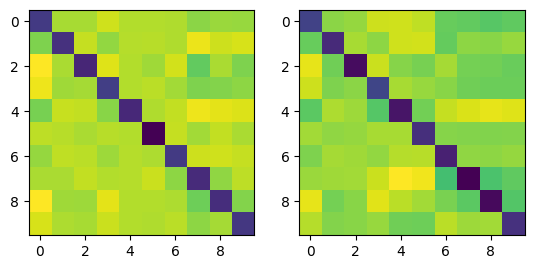

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(L)
ax2.imshow(L_star)